In [1]:
import pandas as pd
import numpy as np
import os
import sys
import torch
from torch.utils.data import Dataset
sys.path.append(os.path.abspath(".."))

## Load and Split the data

In [2]:
from utils.loader import load_data_with_logReturn

data_clean = load_data_with_logReturn("../stocks/AAPL.csv")

In [3]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11182 entries, 1980-12-22 to 2025-05-02
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close       11182 non-null  float64
 1   Close           11182 non-null  float64
 2   High            11182 non-null  float64
 3   Low             11182 non-null  float64
 4   Open            11182 non-null  float64
 5   Volume          11182 non-null  int64  
 6   LogReturn       11182 non-null  float64
 7   LogReturn_Lag1  11182 non-null  float64
 8   LogReturn_Lag2  11182 non-null  float64
 9   LogReturn_Lag3  11182 non-null  float64
 10  LogReturn_Lag4  11182 non-null  float64
 11  LogReturn_Lag5  11182 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.1 MB


Feature Engineering for the input layer. Now set the slide window size for 10 days, i.e 10x10 = 100 neurons.

In [4]:
class MLP_Dataset(Dataset):
    def __init__(self, df, window, stride):
        self.window = window
        self.stride = stride
        self.X, self.y = self.create_features(df)

    def create_features(self, df):
        X_list, y_list = [], []
        for i in range(self.window, len(df) - 1, self.stride):
            window_data = df.iloc[i-self.window:i][[
                "Open", "High", "Low", "Close", "Volume",
                "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3", "LogReturn_Lag4", "LogReturn_Lag5"
            ]].values  

            flat_window = window_data.flatten()
            X_list.append(flat_window) 
            y_list.append(df["LogReturn"].iloc[i+1])  # or LogReturn, etc.

        X_array = np.array(X_list)
        y_array = np.array(y_list)
        return torch.tensor(X_array, dtype=torch.float32), torch.tensor(y_array, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
batch_size = 8
window = 50
stride=50

# Normailize data
feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
                "LogReturn_Lag4", "LogReturn_Lag5"]

scaler = StandardScaler()
data_clean_scaler = data_clean.copy()
data_clean_scaler[feature_cols] = scaler.fit_transform(data_clean_scaler[feature_cols])

# Assume data_clean is already prepared
dataset = MLP_Dataset(data_clean_scaler, window, stride)

print(len(dataset))

223


In [6]:
def get_indices_by_date_range(sample_end_dates, start_date, end_date, name=""):
    indices = [
        i for i, date in enumerate(sample_end_dates)
        if start_date <= date <= end_date
    ]
    if len(indices) == 0:
        print(f"[Warning] No {name} samples in interval: {start_date.date()} ~ {end_date.date()}")
    return indices


In [7]:
dataset[0]

(tensor([-0.4863, -0.4862, -0.4861, -0.4861, -0.8263,  2.0773,  0.9898,  0.8432,
         -2.7263, -1.9227, -0.4861, -0.4861, -0.4860, -0.4860, -0.7976,  1.6617,
          2.0771,  0.9897,  0.8432, -2.7256, -0.4860, -0.4860, -0.4858, -0.4859,
         -0.7944,  1.4422,  1.6616,  2.0770,  0.9896,  0.8432, -0.4858, -0.4858,
         -0.4856, -0.4856, -0.7718,  1.7954,  1.4421,  1.6615,  2.0766,  0.9896,
         -0.4857, -0.4857, -0.4855, -0.4856, -0.6594,  3.1078,  1.7952,  1.4420,
          1.6612,  2.0764, -0.4858, -0.4858, -0.4856, -0.4857, -0.7320,  0.4723,
          3.1076,  1.7951,  1.4417,  1.6611, -0.4859, -0.4859, -0.4857, -0.4857,
         -0.8311, -0.8964,  0.4722,  3.1074,  1.7948,  1.4417, -0.4858, -0.4858,
         -0.4857, -0.4857, -0.8732, -1.0481, -0.8965,  0.4721,  3.1066,  1.7946,
         -0.4859, -0.4859, -0.4857, -0.4858, -0.8311,  0.3638, -1.0481, -0.8965,
          0.4722,  3.1063, -0.4860, -0.4860, -0.4859, -0.4859, -0.8029, -0.8032,
          0.3637, -1.0482, -

In [8]:
# Get all timestamps from the original DataFrame
all_dates = data_clean.index.tolist()

# Determine the ending date of each sample (starts from index=10 due to window)
sample_end_dates = [
    all_dates[i] for i in range(window, len(data_clean) - 1, stride)
]  # offset by window size


In [9]:
sample_end_dates

[Timestamp('1981-03-05 00:00:00'),
 Timestamp('1981-05-15 00:00:00'),
 Timestamp('1981-07-28 00:00:00'),
 Timestamp('1981-10-07 00:00:00'),
 Timestamp('1981-12-17 00:00:00'),
 Timestamp('1982-03-02 00:00:00'),
 Timestamp('1982-05-12 00:00:00'),
 Timestamp('1982-07-23 00:00:00'),
 Timestamp('1982-10-04 00:00:00'),
 Timestamp('1982-12-14 00:00:00'),
 Timestamp('1983-02-24 00:00:00'),
 Timestamp('1983-05-06 00:00:00'),
 Timestamp('1983-07-19 00:00:00'),
 Timestamp('1983-09-28 00:00:00'),
 Timestamp('1983-12-08 00:00:00'),
 Timestamp('1984-02-21 00:00:00'),
 Timestamp('1984-05-02 00:00:00'),
 Timestamp('1984-07-13 00:00:00'),
 Timestamp('1984-09-24 00:00:00'),
 Timestamp('1984-12-04 00:00:00'),
 Timestamp('1985-02-14 00:00:00'),
 Timestamp('1985-04-29 00:00:00'),
 Timestamp('1985-07-10 00:00:00'),
 Timestamp('1985-09-19 00:00:00'),
 Timestamp('1985-12-02 00:00:00'),
 Timestamp('1986-02-12 00:00:00'),
 Timestamp('1986-04-25 00:00:00'),
 Timestamp('1986-07-08 00:00:00'),
 Timestamp('1986-09-

In [10]:

# Define date boundaries for each split
train_val_test_start_date = pd.Timestamp("1980-01-01")
train_val_test_end_date = pd.Timestamp("2024-12-31")

real_world_start_date = pd.Timestamp("2025-01-01")
real_world_end_date = pd.Timestamp("2025-05-02")

main_indices = get_indices_by_date_range(
    sample_end_dates, train_val_test_start_date, train_val_test_end_date, "train/val/test"
)


In [11]:
main_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [12]:
import random

random.seed(42)
random.shuffle(main_indices)

In [13]:
total = len(main_indices)
train_end = int(total * 0.7)
val_end = int(total * 0.85)

train_indices = main_indices[:train_end]
val_indices = main_indices[train_end:val_end]
test_indices = main_indices[val_end:]


In [14]:
total = len(main_indices)
train_end = int(total * 0.7)
val_end = int(total * 0.85)

train_indices = main_indices[:train_end]
val_indices = main_indices[train_end:val_end]
test_indices = main_indices[val_end:]

# Create subsets
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

y_train = data_clean["LogReturn"].iloc[[window + i + 1 for i in train_indices]].values
y_val   = data_clean["LogReturn"].iloc[[window + i + 1 for i in val_indices]].values
y_test  = data_clean["LogReturn"].iloc[[window + i + 1 for i in test_indices]].values


In [15]:
val_indices

[168,
 17,
 49,
 147,
 92,
 158,
 160,
 75,
 141,
 20,
 96,
 31,
 137,
 117,
 11,
 67,
 198,
 88,
 91,
 24,
 97,
 202,
 211,
 86,
 201,
 39,
 186,
 87,
 205,
 178,
 40,
 1,
 71]

In [16]:
real_world_indices = get_indices_by_date_range(
            sample_end_dates,
            real_world_start_date,
            real_world_end_date,
            name="Real_World"
        )

In [34]:
real_world_indices

[221, 222]

In [17]:
real_world_loader = DataLoader(
            Subset(dataset, real_world_indices), batch_size=batch_size
        )

X_real = data_clean.iloc[[window + i + 1 for i in real_world_indices]]
y_real_world = [data_clean["LogReturn"].iloc[window + i + 1] for i in real_world_indices]

In [18]:
# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [19]:
print("Number of samples:", len(dataset))
print("Input feature shape:", dataset[0][0].shape)
print("Target value:", dataset[0][1])

Number of samples: 223
Input feature shape: torch.Size([500])
Target value: tensor(-0.0097)


## Model

Define MLP Model

In [20]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)

        x = self.fc5(x)
        return x


Training

In [21]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = MLP(input_size=train_set.dataset.X.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
from tqdm import tqdm

epochs = 20
best_val_loss = float("inf")
best_model_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)
        progress_bar.set_postfix(loss=avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device).unsqueeze(1)
            val_outputs = model(X_val_batch)
            loss = criterion(val_outputs, y_val_batch)
            val_loss += loss.item() * X_val_batch.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict()

if best_model_state is not None:
            model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 0.002065, Val Loss: 0.000914


Epoch 2, Train Loss: 0.001289, Val Loss: 0.000939


Epoch 3, Train Loss: 0.001200, Val Loss: 0.000669


Epoch 4, Train Loss: 0.001152, Val Loss: 0.000699


Epoch 5, Train Loss: 0.000774, Val Loss: 0.000624


Epoch 6, Train Loss: 0.000637, Val Loss: 0.000685


Epoch 7, Train Loss: 0.000520, Val Loss: 0.000985


Epoch 8, Train Loss: 0.000877, Val Loss: 0.000564


Epoch 9, Train Loss: 0.000495, Val Loss: 0.000639


Epoch 10, Train Loss: 0.000403, Val Loss: 0.000653


Epoch 11, Train Loss: 0.000370, Val Loss: 0.000576


Epoch 12, Train Loss: 0.000371, Val Loss: 0.000669


Epoch 13, Train Loss: 0.000371, Val Loss: 0.000682


Epoch 14, Train Loss: 0.000363, Val Loss: 0.000637


Epoch 15, Train Loss: 0.000256, Val Loss: 0.000778


Epoch 16, Train Loss: 0.000253, Val Loss: 0.000742


Epoch 17, Train Loss: 0.000298, Val Loss: 0.000613


Epoch 18, Train Loss: 0.000308, Val Loss: 0.000685


Epoch 19, Train Loss: 0.000190, Val Loss: 0.000737


Epoch 20, Train Loss: 0.000193, Val Loss: 0.000787


In [23]:
from sklearn.metrics import r2_score, root_mean_squared_error

if best_model_state is not None:
    model.load_state_dict(best_model_state)
else:
    print("[Warning] best_model_state is None — using current model weights.")

model.eval()
preds_train, preds_val, preds_test, preds_real = [], [], [], []

with torch.no_grad():
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_train.extend(y_pred.cpu().numpy().flatten())

    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_val.extend(y_pred.cpu().numpy().flatten())

    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_test.extend(y_pred.cpu().numpy().flatten())

    for X_batch, _ in real_world_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds_real.extend(y_pred.cpu().numpy().flatten())

y_train_pred = np.array(preds_train)
y_val_pred   = np.array(preds_val)
y_test_pred  = np.array(preds_test)
y_real_pred  = np.array(preds_real)

# Print evaluation metrics
print({
    "Train R2": r2_score(y_train, y_train_pred),
    "Val R2": r2_score(y_val, y_val_pred),
    "Test R2": r2_score(y_test, y_test_pred),
    "Train RMSE": root_mean_squared_error(y_train, y_train_pred),
    "Val RMSE": root_mean_squared_error(y_val, y_val_pred),
    "Test RMSE": root_mean_squared_error(y_test, y_test_pred),
})

{'Train R2': -0.2750952700141267, 'Val R2': -0.03864725472460262, 'Test R2': -0.45921357427607834, 'Train RMSE': 0.03623422470592378, 'Val RMSE': 0.04631085610203369, 'Test RMSE': 0.03569256635131}


Trading Simulation

In [24]:
from utils.eval import evaluate_strategy_performance_real_world,calculate_average_pnl

returns, capital, positions = evaluate_strategy_performance_real_world(
            y_real_world,
            y_real_pred,
        )

pnl_result = calculate_average_pnl(positions, y_real_world)

In [27]:
from utils.plotter import long_short_position_graph

result = {
            **returns,
            **capital,
            "Average PnL": pnl_result["average_pnl"],
            "Average PnL (%)": pnl_result["average_pnl_percent"]
        }


In [28]:
result

{'Real Cumulative Return': np.float64(-0.03636126915241611),
 'Real Sharpe Ratio': np.float64(-1714.874648832105),
 'Final Real Capital': np.float64(963638.7308475839),
 'Total Real Profit': np.float64(-36361.269152416105),
 'Average PnL': np.float64(-18348.962630661325),
 'Average PnL (%)': np.float64(-1.8348962630661325)}

In [32]:
y_real_true = pd.Series(y_real_world, index=X_real.index)


In [33]:
X_real

,Adj Close,Close,High,Low,Open,Volume,LogReturn,LogReturn_Lag1,LogReturn_Lag2,LogReturn_Lag3,LogReturn_Lag4,LogReturn_Lag5
Date,,,,,,,,,,,,
1982-01-20,0.069538,0.090402,0.090960,0.090402,0.090402,25827200,0.018691,-0.024844,0.018575,0.064546,0.047788,-0.006968
1982-01-21,0.070825,0.092076,0.092634,0.092076,0.092076,33331200,0.018348,0.018691,-0.024844,0.018575,0.064546,0.047788


In [ ]:
fig = long_short_position_graph(X_real, y_real_true, y_real_pred, positions)


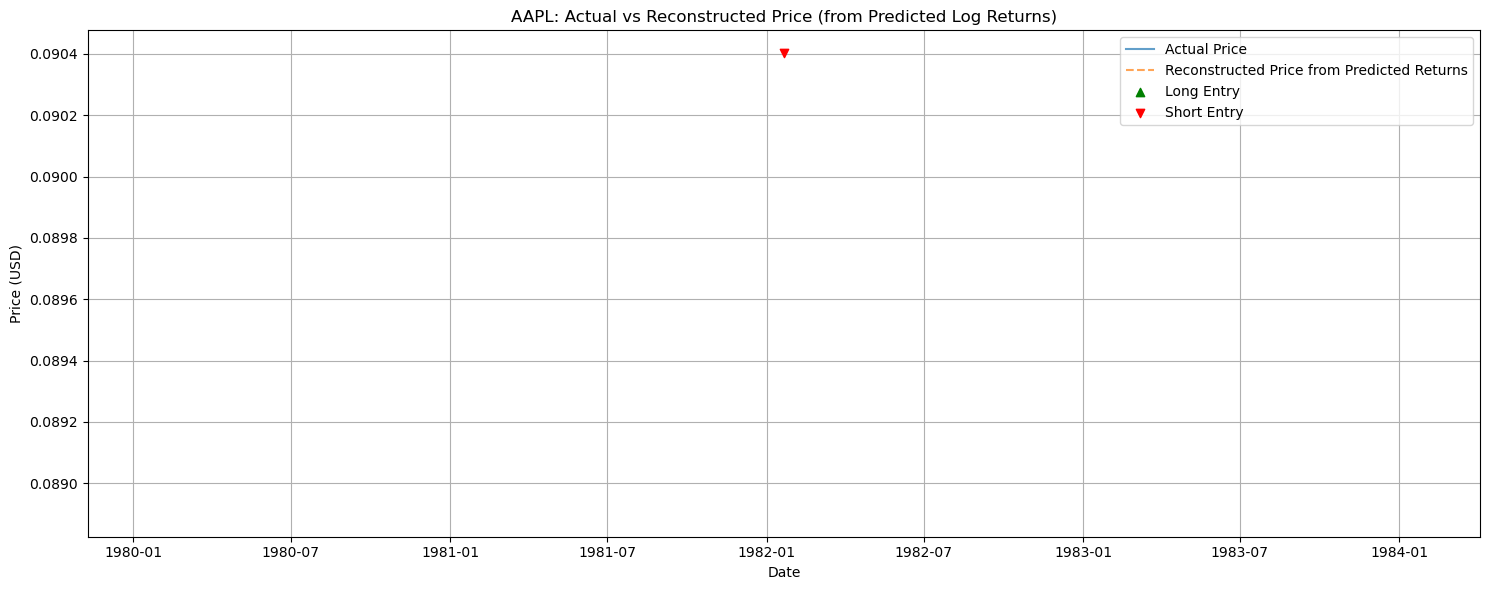

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Long/Short markers
long_signals = (positions == 1)
short_signals = (positions == -1)

# Dates and data alignment
test_dates = y_real_true.index
plot_dates = test_dates[1:]

P_t = X_real.Close.iloc[:-1].values
r_hat_t_plus_1 = y_test_pred[1:]
P_hat_t_plus_1 = P_t * np.exp(r_hat_t_plus_1)

# Ensure same length across all series
min_len = min(len(plot_dates), len(P_hat_t_plus_1))
plot_dates = plot_dates[:min_len]
P_hat_t_plus_1 = P_hat_t_plus_1[:min_len]
actual_prices = X_real.Close.values[:min_len]

long_signals = long_signals[1:][:min_len]
short_signals = short_signals[1:][:min_len]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(plot_dates, actual_prices, label="Actual Price", alpha=0.7)
plt.plot(plot_dates, P_hat_t_plus_1, label="Reconstructed Price from Predicted Returns", linestyle="--", alpha=0.7)

plt.scatter(plot_dates[long_signals], actual_prices[long_signals], marker='^', color='green', label='Long Entry', zorder=5)
plt.scatter(plot_dates[short_signals], actual_prices[short_signals], marker='v', color='red', label='Short Entry', zorder=5)

plt.title("AAPL: Actual vs Reconstructed Price (from Predicted Log Returns)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
